In [21]:
import pandas as pd
import dvc.api

In [2]:
df_train = pd.concat([ 
    pd.read_json('/workspaces/multitask-llm-rnd/datasets/data/query_label/processed3/Mixed_Human_Inferred_Query_Classification_Train_DedupOverlap.json', lines=True), 
    pd.read_json('/workspaces/multitask-llm-rnd/datasets/data/query_label/processed3/OnlyHuman_Labelled_Query_Classification_Train_DedupOverlap.json', lines=True),
    pd.read_json('/workspaces/multitask-llm-rnd/datasets/data/query_label/processed3/OnlyInferred_Query_Classification_Train_DedupOverlap.json', lines=True)
])


In [11]:
df_train_unknown_group = df_train[df_train.category == 'unknown'].drop_duplicates('query').groupby('query').agg({'category': lambda x: [i for i in x]}).reset_index()
df_train_group = df_train.groupby('query').agg({'category': lambda x: [i for i in x]}).reset_index()

In [12]:
df_train_group_merge = df_train_group.merge(df_train_unknown_group.rename(columns={'category': 'category_unknown'}), on='query', how='left')

In [18]:
df_train_group_merge.loc[~df_train_group_merge.category_unknown.isna()].category.apply(lambda x: len(x) == 1 and x[0] == 'unknown').all()

True

In [24]:
df_train_group

,query,category
0,!!! chaquetas y pantalones camisas y polos de ...,[men's clothing > tops & tees > polo shirts]
1,!ed light,[home improvement > lights & lighting > under ...
2,!efiel dresses,[novelty & special use > stage & dance wear > ...
3,!electronic pulse snap pads,[beauty & health > health care > massage produ...
4,!entes multifocales,[apparel accessories > men's glasses > men's r...
...,...,...
2559396,🥒 rick pipes,[home & garden > household merchandise > light...
2559397,🥶 winter sale 🥶 warm hat knit visor beanie fle...,[apparel accessories > women's accessories > w...
2559398,🧊cute ice ball molds to make your summer even ...,"[home & garden > kitchen,dining & bar > ice cr..."
2559399,🧹squeeze silicone broom sweeping water and pet...,[home & garden > household cleaning > househol...


In [22]:
df_train_pseudo = pd.read_json(dvc.api.get_url( 
    'modelling/notebooks/query_classify_pseudolabel/wish_queries_with_timestamp_3yr_all_sample_12M_headtail_qcv2_pseudolabel_train.json',
    repo='git@github.com:ContextLogic/multitask-llm-rnd.git'
), lines=True)

In [25]:
df_train_pseudo_group = df_train_pseudo.groupby('query').agg({'category': lambda x: [i for i in x]}).reset_index()

In [29]:
len(df_train_pseudo_group)

11175669

In [27]:
df_train_all_group = df_train_pseudo_group.merge(df_train_group.rename(columns={'category': 'category_real'}), on='query', how='outer')

In [37]:
df_train_all_group.loc[(~df_train_all_group.category.isna()) & (~df_train_all_group.category_real.isna()), 'category_merge'] = \
    (df_train_all_group.loc[(~df_train_all_group.category.isna()) & (~df_train_all_group.category_real.isna()), 'category'] + \
     df_train_all_group.loc[(~df_train_all_group.category.isna()) & (~df_train_all_group.category_real.isna()), 'category_real']).apply(lambda x: list(set(x)))

In [39]:
df_train_all_group.loc[(df_train_all_group.category_merge.isna()) & (~df_train_all_group.category_real.isna()), 'category_merge'] = \
    df_train_all_group.loc[(df_train_all_group.category_merge.isna()) & (~df_train_all_group.category_real.isna()), 'category_real']
df_train_all_group.loc[(df_train_all_group.category_merge.isna()) & (~df_train_all_group.category.isna()), 'category_merge'] = \
    df_train_all_group.loc[(df_train_all_group.category_merge.isna()) & (~df_train_all_group.category.isna()), 'category']

In [41]:
df_train_all_group.category_merge.isna().any()

False

In [43]:
del df_train_all_group['category']
del df_train_all_group['category_real']
df_train_all_group = df_train_all_group.rename(columns={'category_merge': 'category'})

<AxesSubplot: ylabel='Frequency'>

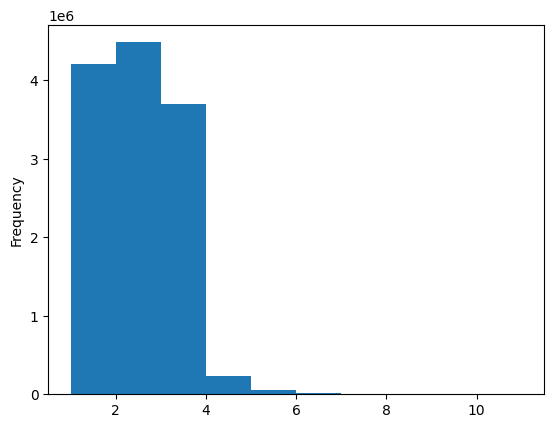

In [45]:
df_train_all_group.category.apply(len).plot.hist()

<AxesSubplot: ylabel='category'>

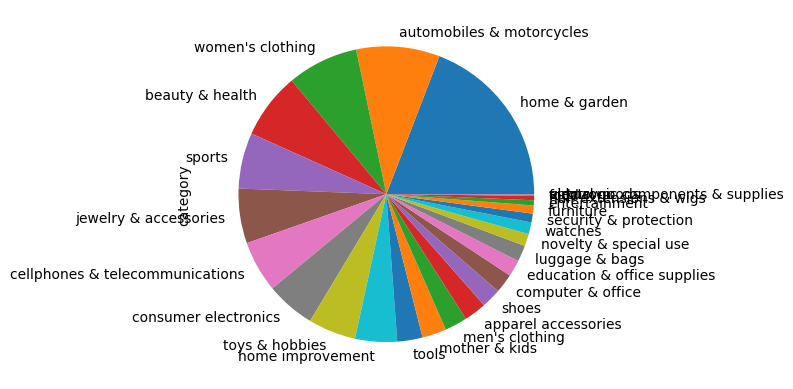

In [49]:
df_train_all_group.category.apply(lambda x: ' > '.join(x[0].split(' > ')[:1])).value_counts().plot.pie()

In [50]:
df_tax = pd.read_json(
    dvc.api.get_url(
        'datasets/data/taxonomy/wish_newtax.json',
        repo='git@github.com:ContextLogic/multitask-llm-rnd.git'
    ), lines=True
)
paths = set(df_tax[df_tax.category_path.apply(len) > 0]['category_path'].apply(lambda x: x.lower().strip()))

In [52]:
df_train_all_group[df_train_all_group['query'] != df_train_all_group['query'].str.lower()]

,query,category
10981410,Ꭲシャツ,"[women's clothing > tops > tees, men's clothin..."
10981555,Სwire tires r 15 4x100,[automobiles & motorcycles > auto replacement ...
11094740,ヴィトン Ꭲシャツ,"[men's clothing > tops & tees > t-shirts, men'..."
11100071,半袖Ꭲシャツ,"[women's clothing > tops > tees, men's clothin..."


In [58]:
paths.add('unknown')

In [59]:
df_train_all_group.category.apply(lambda x: all([i in paths for i in x])).all()

False

In [60]:
df_train_all_group[df_train_all_group.category.apply(lambda x: not all([i in paths for i in x]))]

,query,category
10331566,vitamin c tablets,"[beauty & health > health care, , beauty & hea..."
12175608,peppermint oil softgels,[]


In [63]:
df_train_all_group.loc[10331566, 'category'] = ['beauty & health > health care',
  'beauty & health > health care > personal health care',
  'beauty & health > health care > personal health care > pill cases & splitters']

,query,category
0,dr martin,[shoes > women's shoes > women's boots]
1,犬靴,[home & garden > pet products > dog clothing &...
2,0jesus headband,[apparel accessories > women's hair accessories]
3,! 12,[computer & office > computer components > cpus]
4,! asus rog phone 2,[cellphones & telecommunications > cellphones]
...,...,...
12678842,🥒 rick pipes,[home & garden > household merchandise > light...
12678843,🥶 winter sale 🥶 warm hat knit visor beanie fle...,[apparel accessories > women's accessories > w...
12678844,🧊cute ice ball molds to make your summer even ...,"[home & garden > kitchen,dining & bar > ice cr..."
12678845,🧹squeeze silicone broom sweeping water and pet...,[home & garden > household cleaning > househol...


In [65]:
df_train_all_group = df_train_all_group.drop(12175608)

In [66]:
df_train_all_group[df_train_all_group.category.apply(lambda x: not all([i in paths for i in x]))]

,query,category


In [68]:
def remove_prefix_strings(strings_in):
    res = set(strings_in)
    strings = sorted(res, key=len)
    for i in range(len(strings)):
        for j in range(i+1, len(strings)):
            if strings[j].startswith(strings[i]):
                res.remove(strings[i])
                break
    return list(res)

In [69]:
df_train_all_group['category_dedup'] = df_train_all_group['category'].apply(remove_prefix_strings)

<AxesSubplot: ylabel='Frequency'>

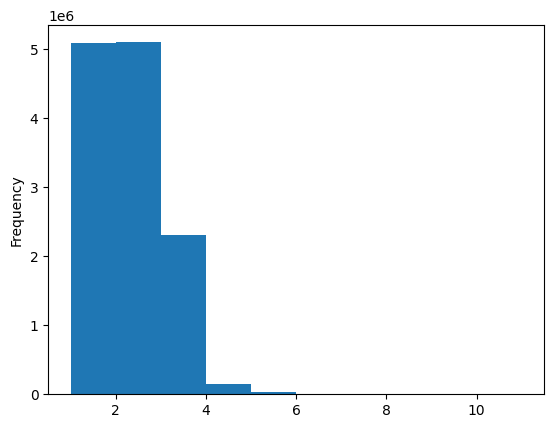

In [70]:
df_train_all_group.category_dedup.apply(len).plot.hist()

In [76]:
df_train_all_group['category'] = df_train_all_group['category_dedup']
del df_train_all_group['category_dedup']

In [78]:
df_train_all_group['category'] = df_train_all_group['category'].apply(lambda x: '\n'.join(x))

In [86]:
df_val = pd.read_json(dvc.api.get_url( 
    'datasets/data/query_label/processed2/Human_Labelled_Query_Classification_Val_processed_multilabel_seqclf.json',
    repo='git@github.com:ContextLogic/multitask-llm-rnd.git'
), lines=True)

df_test = pd.read_json(dvc.api.get_url( 
    'datasets/data/query_label/processed/Offshore_Labelled_Query_Classification_Test_V2.json',
    repo='git@github.com:ContextLogic/multitask-llm-rnd.git'
), lines=True)

In [104]:
df_valtest = pd.concat([df_val[['query']], df_val[['query']]])

In [108]:
set(df_val['query']).intersection(set(df_test['query']))

set()

In [96]:
df_human = pd.concat([
    pd.read_json('/workspaces/multitask-llm-rnd/datasets/data/query_label/processed3/Mixed_Human_Inferred_Query_Classification_Train_DedupOverlap.json', lines=True), 
    pd.read_json('/workspaces/multitask-llm-rnd/datasets/data/query_label/processed3/OnlyHuman_Labelled_Query_Classification_Train_DedupOverlap.json', lines=True),
])

In [97]:
set(df_test['query']).intersection(set(df_human['query']))

set()

In [98]:
len(set(df_test['query']).intersection(set(df_train_all_group['query'])))

13100

In [99]:
df_train_all_group.merge()

,query,category
0,dr martin,shoes > women's shoes > women's boots
1,犬靴,home & garden > pet products > dog clothing & ...
2,0jesus headband,apparel accessories > women's hair accessories
3,! 12,computer & office > computer components > cpus
4,! asus rog phone 2,cellphones & telecommunications > cellphones
...,...,...
12678842,🥒 rick pipes,home & garden > household merchandise > lighte...
12678843,🥶 winter sale 🥶 warm hat knit visor beanie fle...,apparel accessories > women's accessories > wo...
12678844,🧊cute ice ball molds to make your summer even ...,"home & garden > kitchen,dining & bar > ice cre..."
12678845,🧹squeeze silicone broom sweeping water and pet...,home & garden > household cleaning > household...


In [110]:
df_valtest['valtest'] = True

In [111]:
df_train_all_group = df_train_all_group.merge(df_valtest, on='query', how='left')

In [113]:
df_train_all_group_novaltest = df_train_all_group[df_train_all_group.valtest.isna()]

In [115]:
len(df_train_all_group_novaltest) / len(df_train_all_group)

0.9992407554884981

In [117]:
del df_train_all_group_novaltest['valtest']

In [119]:
df_train_all_group.to_json(
    'processed4/Mixed_Human_Inferred_Modelpseudo_Query_Classification_Train_DedupOverlap_processed_multilabel_seqclf.json', lines=True, orient='records')